### Import Libraries

In [3]:
import os
import cv2
import copy
import math
import time
import tarfile
import numbers
import threading
import queue as Queue
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
#from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, DataLoader, Dataset
from torchsummary import summary

In [4]:
import pickle
import mxnet as mx
from mxnet import recordio
from mxnet import ndarray as nd

In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [6]:
random_seed = 42
torch.manual_seed(random_seed);

In [7]:
torch.set_printoptions(edgeitems=5)

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()

In [10]:
device

device(type='cuda')

In [11]:
class ArcFaceDataset(Dataset):
    def __init__(self, root_dir):
        super(ArcFaceDataset, self).__init__()

        self.transform = None
        
        self.root_dir = root_dir
        #root_dir2 = "D:/Face/faces_emore/" #"faces_emore/"
        
        path_imgrec = os.path.join(root_dir, 'train.rec')
        path_imgidx = os.path.join(root_dir, 'train.idx')
        self.imgrec = mx.recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')
        s = self.imgrec.read_idx(0)
        header, _ = mx.recordio.unpack(s)
        
        if header.flag > 0:
            self.header0 = (int(header.label[0]), int(header.label[1]))
            self.imgidx = np.array(range(1, int(header.label[0])))
        else:
            self.imgidx = np.array(list(self.imgrec.keys)) #List of numbers 1 .... 5908396

    def __getitem__(self, index):
        idx = self.imgidx[index]
        s = self.imgrec.read_idx(idx)
        header, img = mx.recordio.unpack(s)
        label = header.label
        if not isinstance(label, numbers.Number):
            label = label[0]
        label = torch.tensor(label, dtype=torch.long)
        sample = mx.image.imdecode(img).asnumpy()
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, label

    def __len__(self):
        return len(self.imgidx)

In [12]:
root_dir1 = "../faces_emore/" #For Ubuntu
root_dir2 = "D:/Face/faces_emore/" #For Windows

dataset = ArcFaceDataset(root_dir1)

In [13]:
len(dataset)

5822653

### Step 1a) Fetch the LFW dataset

#### Option i) Fetch the kaggle downloaded LFW dataset

In [14]:
# main_dir = '../../datasets/LFW' #For Ubuntu
# #main_dir = 'D:/Face/LFW' #For Windows
# data_dir = main_dir + "/lfw-deepfunneled/lfw-deepfunneled"

# print(os.listdir(main_dir))
# classes = os.listdir(data_dir)
# print(len(classes))

In [15]:
# img_Aaron_Eckhart = os.listdir(data_dir + "/Aaron_Eckhart")
# print('No. of training examples for Aaron_Eckhart:', len(img_Aaron_Eckhart))
# print(img_Aaron_Eckhart[:])

In [16]:
# dataset = ImageFolder(data_dir, transform=ToTensor())

In [17]:
# len(dataset)

In [18]:
# print(dataset.classes)

In [19]:
# img, label = dataset[13232]
# print(img.shape, label)

In [20]:
# img, label = dataset[1500]
# #img = torch.reshape(img, (size2, size2, 3))
# img = img.permute(1, 2, 0)

# plt.imshow(img)
# plt.title('label = ' + str(label))

In [21]:
# img, label = dataset[0]
# #img = torch.reshape(img, (size2, size2, 3))
# img = img.permute(1, 2, 0)

# plt.imshow(img)
# plt.title('label = ' + str(label))

#### Option ii) Fetch the sklearn library LFW dataset

In [22]:
# from sklearn.datasets import fetch_lfw_pairs

In [23]:
# data_path1 = "D:/Face/send/" #Windows
# data_path2 = "../../datasets/" #Ubuntu
# lfw_people = fetch_lfw_pairs(data_home = data_path2, subset='test', color=True, resize=1)

In [24]:
# pairs = lfw_people.pairs
# targets = lfw_people.target

In [25]:
# pairs.shape, targets.shape

In [26]:
# np.count_nonzero(targets==1)

In [27]:
# idx = 0
# pair = pairs[idx]
# img1 = pair[0]
# img2 = pair[1]

# plt.imshow(img1.astype(int))
# plt.show()

# plt.imshow(img2.astype(int))
# plt.show()

# print("actual: ", targets[idx])

In [28]:
#img1.astype(int)

#### Option iii) Fetch the mx LFW dataset

In [29]:
image_size = [112, 112]

In [30]:
path = "../faces_emore/lfw.bin" #For Ubuntu
#path = "D:/Face/faces_emore/lfw.bin" #For Windows

In [31]:
@torch.no_grad()
def load_bin(path, image_size=[112, 112]):
    with open(path, 'rb') as f:
        bins, issame_list = pickle.load(f, encoding='bytes')
    data_list = []
    
    for idx in np.arange(0, len(issame_list)*2, 2):
        img = []
        
        _bin1 = bins[idx]
        _bin2 = bins[idx+1]
        img1 = mx.image.imdecode(_bin1)
        img2 = mx.image.imdecode(_bin2)
        if img1.shape[1] != image_size[0]:
            img1 = mx.image.resize_short(img1, image_size[0])
        if img2.shape[1] != image_size[0]:
            img2 = mx.image.resize_short(img2, image_size[0])
            
        img1 = img1.asnumpy()
        img2 = img2.asnumpy()

        img.append(img1)
        img.append(img2)
        img = np.array(img)
        data_list.append(img)
        
        if idx % 1000 == 0:
            print('loading bin', idx)
    
    data_list = np.array(data_list)
    
    issame_list = np.array(issame_list)
    issame_list = issame_list.astype(int)
    
    print(data_list.shape, issame_list.shape)
    return data_list, issame_list

In [32]:
X, y = load_bin(path)

loading bin 0
loading bin 1000
loading bin 2000
loading bin 3000
loading bin 4000
loading bin 5000
loading bin 6000
loading bin 7000
loading bin 8000
loading bin 9000
loading bin 10000
loading bin 11000
(6000, 2, 112, 112, 3) (6000,)


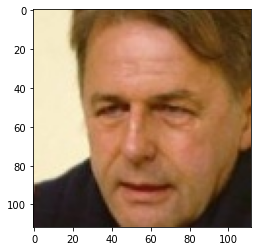

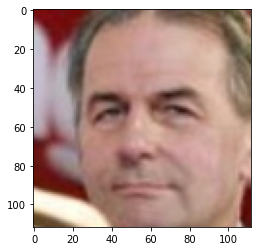

actual:  1


In [33]:
idx = 100
pair = X[idx]
img1 = pair[0]
img2 = pair[1]

plt.imshow(img1)
plt.show()

plt.imshow(img2)
plt.show()

print("actual: ", y[idx])

In [34]:
# img1

### Step 2a) Model Architecture - Network

In [35]:
def conv_2d(ni, nf, ks, stride=1):
    return nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=ks, stride=stride, padding=ks//2, bias=False)

def bn_relu_conv(ni, nf, ks):
    return nn.Sequential(nn.BatchNorm2d(ni), 
                       nn.ReLU(inplace=True),
                       conv_2d(ni, nf, ks))

In [36]:
class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        if ni > 100:
            temp = ni * 2
        else:
            temp = ni
        self.bn = nn.BatchNorm2d(temp)
        self.conv1 = conv_2d(temp, ni, 1, stride)
        self.conv2 = bn_relu_conv(ni, ni, ks=3)
        self.conv3 = bn_relu_conv(ni, nf, ks=1)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(temp, nf, 1, stride)

    def forward(self, x):
        #print("Inside Res Block1")
        #print(x.shape)
        x = F.relu(self.bn(x), inplace=True)
        #print(x.shape)
        r1 = self.shortcut(x)
        #print(r1.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) * 0.2
        #print(x.shape)
        return x.add_(r1)

In [37]:
class ResBlock2(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, 1, stride)
        self.conv2 = bn_relu_conv(nf, nf, ks=3)
        self.conv3 = bn_relu_conv(nf, ni, ks=1)
        self.shortcut = lambda x: x
#        if ni != nf:
#            self.shortcut = conv_2d(ni, nf, 1, 1)

    def forward(self, x):
        #print("Inside Res Block2")
        #print(x.shape)
        x = F.relu(self.bn(x), inplace=True)
        #print(x.shape)
        r = self.shortcut(x)
        #print(r.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) * 0.2
        return x.add_(r)

In [38]:
def make_group(N, ni, nf, stride):
    start = ResBlock(ni, nf, stride)
    rest = [ResBlock2(nf, ni) for j in range(1, N)]
    return [start] + rest

In [39]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x.view(x.size(0), -1)

In [40]:
class MyResNet(nn.Module):
    def __init__(self, n_groups, N, k=1, n_start=64):
        super().__init__()
        #Increase channels
        self.layers = [conv_2d(3, 64, ks=7, stride=2)]
        self.layers += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
        n_channels = [n_start]

        #Add groups
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            self.layers += make_group(N[i], n_channels[i], n_channels[i]*4, stride)

        #Pool, Flatten, and add linear layer for classification  
        self.layers += [nn.BatchNorm2d(n_channels[n_groups]*2),
                        nn.ReLU(inplace=True),
                        nn.AdaptiveAvgPool2d(1),
                        #nn.AvgPool2d(kernel_size=2, stride=2),
                        Flatten(),
                        nn.Linear(n_channels[n_groups]*2, 512)
                       ]
        #self.fc = nn.Linear(512, n_classes)
        self.features = nn.Sequential(*self.layers)
        
    def forward(self, x):
        embed = self.features(x)
        #print(embed.shape)
        return embed #self.fc(embed)

In [41]:
#Number of blocks at various groups
N_50 = [3, 4, 6, 3]
N_101 = [3, 4, 23, 3]
N_152 = [3, 8, 36, 3]

def ResNet50():
    return MyResNet(4, N_50, k=2)

def ResNet101():
    return MyResNet(4, N_101, k=2)

def ResNet152():
    return MyResNet(4, N_152, k=2)

In [42]:
loaded_model = ResNet50()
to_device(loaded_model, device)

MyResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv3): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): ResBlock2(
      (bn): 

In [ ]:
class MyResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=64):
        super().__init__()
        #Increase channels
        self.layers = [conv_2d(3, 64, ks=7, stride=2)]
        self.layers += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
        n_channels = [n_start]

        #Add groups
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            self.layers += make_group(N[i], n_channels[i], n_channels[i]*4, stride)

        #Pool, Flatten, and add linear layer for classification  
        self.layers += [nn.BatchNorm2d(n_channels[n_groups]*2),
                   nn.ReLU(inplace=True),
                   nn.AdaptiveAvgPool2d(1),
                   #nn.AvgPool2d(kernel_size=2, stride=2), 
                   Flatten()]
        self.fc = nn.Linear(n_channels[n_groups]*2, n_classes)
    
        self.features = nn.Sequential(*self.layers)
        
    def forward(self, x):
        #a = self.features(x)
        #print(a.shape)
        temp = self.features(x)
        return self.fc(temp)

In [ ]:
#Number of blocks at various groups
N_50 = [3, 4, 6, 3]
N_101 = [3, 4, 23, 3]
N_152 = [3, 8, 36, 3]

def ResNet50(n_classes):
    return MyResNet(4, N_50, n_classes, k=2)

def ResNet101(n_classes):
    return MyResNet(4, N_101, n_classes, k=2)

def ResNet152(n_classes):
    return MyResNet(4, N_152, n_classes, k=2)

In [ ]:
# def test():
#     net = ResNet50(50)
#     x = torch.randn(2, 3, 224, 224)
#     y = net(x)
#     print(y.shape)
#     print(y)
#     print(y[0].shape)
#     to_device(net, device)
#     summary(net, input_size = (3, 62, 47), batch_size = -1)
#     return net

In [ ]:
#model_net = test()

In [ ]:
loaded_model = ResNet50(85742)
to_device(loaded_model, device)

In [43]:
summary(loaded_model, input_size = (3, 50, 50), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 25, 25]           9,408
         MaxPool2d-2           [-1, 64, 13, 13]               0
       BatchNorm2d-3           [-1, 64, 13, 13]             128
            Conv2d-4          [-1, 256, 13, 13]          16,384
            Conv2d-5           [-1, 64, 13, 13]           4,096
       BatchNorm2d-6           [-1, 64, 13, 13]             128
              ReLU-7           [-1, 64, 13, 13]               0
            Conv2d-8           [-1, 64, 13, 13]          36,864
       BatchNorm2d-9           [-1, 64, 13, 13]             128
             ReLU-10           [-1, 64, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]          16,384
         ResBlock-12          [-1, 256, 13, 13]               0
      BatchNorm2d-13          [-1, 256, 13, 13]             512
           Conv2d-14           [-1, 64,

In [ ]:
del loaded_model.fc

### Step 2b) Loading the pre-trained Model

In [ ]:
# loaded_model.load_state_dict(
#     torch.load("../Checkpoints/ResNet50_Softmax/ResNet50_Softmax_26_Feb_features_89acc.pth"))
# loaded_model.load_state_dict(
#     torch.load("../Checkpoints/ResNet50_Softmax/ResNet50_Softmax_27_Feb_features_91acc.pth"))
loaded_model.load_state_dict(
    torch.load("../Checkpoints/ResNet50_Softmax/ResNet50_Softmax_28_Feb_features_97acc.pth"))

In [ ]:
#model.layers

In [ ]:
for param in loaded_model.parameters():
    param.requires_grad = False

In [ ]:
loaded_model.fc = nn.Identity(54, unused_argument1=0.1, unused_argument2=False)

In [ ]:
to_device(loaded_model, device)

In [ ]:
summary(loaded_model, input_size = (3, 50, 50), batch_size = -1)

### Step 2b) Loading the pre-trained Model : Option2

In [44]:
class CosFace(nn.Module):
    def __init__(self, in_features=2048, out_features=5749, s=64.0, m=0.35):
        super(CosFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.kernel = nn.Parameter(torch.FloatTensor(in_features, out_features))
        nn.init.normal_(self.kernel, std=0.01)

    def forward(self, logits, labels):
        logits = F.normalize(logits, p=2.0, dim=1) #l2_norm(logits, axis=1)
        kernel_norm = F.normalize(self.kernel, p=2.0, dim=0) #l2_norm(self.kernel, axis=0)
        cos_theta = torch.mm(logits, kernel_norm)
        cos_theta = cos_theta.clamp(-1, 1)  # for numerical stability
        index = torch.where(labels != -1)[0]
        m_hot = torch.zeros(index.size()[0], cos_theta.size()[1]).to(device)
        m_hot.scatter_(1, labels[index, None], self.m).to(device)
        cos_theta[index] -= m_hot
        ret = cos_theta * self.s
        return ret

In [45]:
new_logits = CosFace()

In [ ]:
to_device(new_logits, device)
#new_logits.to(device)

In [ ]:
checkpoint = torch.load("../Checkpoints/ResNet50_CosFacev2/2048-d/ResNet50_CosFace_28_Feb_5.pt")
loaded_model.load_state_dict(checkpoint['model_state_dict'])
#opt1 = checkpoint['model_optimizer_state_dict']
#opt2 = checkpoint['fc_optimizer_state_dict']
#opt2['state'][0]['momentum_buffer']
#n.kernel.shape

# train_acc = checkpoint['train_acc']
# val_acc = checkpoint['val_acc']
# print(train_acc, val_acc)

val_acc = checkpoint['acc']
print(val_acc)

In [48]:
checkpoint = torch.load("../Checkpoints/ResNet50_CosFacev2/512-d/ResNet50_CosFace_14_Mar_15.pt")
loaded_model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
#opt1 = checkpoint['model_optimizer_state_dict']
#opt2 = checkpoint['fc_optimizer_state_dict']
#opt2['state'][0]['momentum_buffer']
new_logits = checkpoint['new_logits']
#n.kernel.shape
train_acc = checkpoint['train_acc']
val_acc = checkpoint['val_acc']
print(epoch, train_acc, val_acc)

15 0.771655879417525 0.702784814474509


In [49]:
for param in loaded_model.parameters():
    param.requires_grad = False

In [ ]:
loaded_model.fc = nn.Identity(54, unused_argument1=0.1, unused_argument2=False)

In [50]:
to_device(loaded_model, device)

MyResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv3): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): ResBlock2(
      (bn): 

In [ ]:
summary(loaded_model, input_size = (3, 62, 47), batch_size = -1)

### Step 3) Testing the model

In [51]:
def compute_embedding(model, xb, sim_metric):
    with torch.no_grad():
        features = model(xb) #F.normalize(model(xb))
        score = sim_metric(features[0], features[1])
    
    return score

In [52]:
similarity = nn.CosineSimilarity(dim=0, eps=1e-6)

In [53]:
tra = transforms.Compose(
    [#transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
     ])

In [54]:
def ver_accuracy(scores, img_targets, thres_arr):
    targets_tensor = torch.from_numpy(img_targets)
    #print(targets_tensor.shape)
    
    acc_list = []
    
    for thres in thres_arr:
        outputs = scores >= thres
        #print(outputs.shape, outputs)
        outputs = outputs.long()
        #print(outputs.shape, outputs)
        matches = outputs == targets_tensor
        #print(matches.shape, matches)
        matches = matches.long()
        success = torch.count_nonzero(matches)
        acc = success/matches.shape[0] * 100
        acc_list.append(np.round(acc.item(), 2))
        
        print("Thres: ", thres, "| Veri acc.: ", np.round(acc.item(), 2))
    
    return targets_tensor, acc_list

(112, 112, 3)


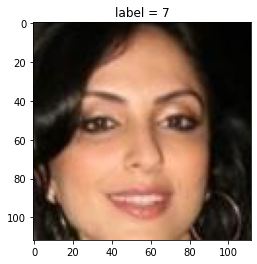

In [55]:
img1, label1 = dataset[501]
print(img1.shape)

plt.imshow(img1)
plt.title('label = ' + str(label1.item()))
plt.show()

(112, 112, 3)


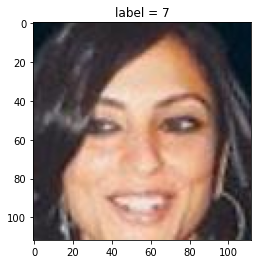

In [63]:
img2, label2 = dataset[502]
print(img2.shape)

plt.imshow(img2)
plt.title('label = ' + str(label2.item()))
plt.show()

In [64]:
img = []
img.append(img1)
img.append(img2)
img = np.array(img)

computed_scores = compute_scores(img)
#print(computed_scores.shape)
print(np.round(computed_scores.item(),3))

-0.856


In [65]:
def compute_scores(img_pairs):
    
    scores = []

    pair = img_pairs
    
    #convert pair to pytorch tensor, normalize
    img1 = pair[0]
    img1 = img1/255
    img1 = tra(img1)
    
    img2 = pair[1]
    img2 = img2/255
    img2 = tra(img2)
        
    #convert into a batch
    new_pair = torch.stack((img1, img2), 0).to(device, dtype=torch.float)
        
    score = compute_embedding(loaded_model, new_pair, similarity)
    #print(score.item())
        
    scores.append(score.item())
    #scores.append(np.abs(score.cpu()))
    
    scores = torch.FloatTensor(scores)
    #print(scores.shape, scores)
    
    return scores

In [66]:
def compute_scores(img_pairs, img_targets):
    
    scores = []
    len = img_targets.shape[0]
    
    for idx in np.arange(0, len):
        pair = img_pairs[idx]
        actual = img_targets[idx]
        
        #convert pair to pytorch tensor, normalize
        img1 = pair[0]
        img1 = img1/255
        img1 = tra(img1)
    
        img2 = pair[1]
        img2 = img2/255
        img2 = tra(img2)
        
        #convert into a batch
        new_pair = torch.stack((img1, img2), 0).to(device, dtype=torch.float)
        
        score = compute_embedding(loaded_model, new_pair, similarity)
        #print(actual, score.item())
        
        scores.append(score.item())
        #scores.append(np.abs(score.cpu()))
    
    scores = torch.FloatTensor(scores)
    #print(scores.shape, scores)
    
    return scores

In [67]:
computed_scores = compute_scores(X, y)
print(computed_scores.shape)
print(computed_scores)

torch.Size([6000])
tensor([-0.8409, -0.8300, -0.8234, -0.8686, -0.8631,  ..., -0.9065, -0.8593,
        -0.8640, -0.8858, -0.8832])


In [68]:
torch.min(computed_scores), torch.max(computed_scores)

(tensor(-0.9320), tensor(-0.6853))

In [69]:
thresholds = [0.099, 0.1, 0.2, 0.22, 0.24, 0.25, 0.255, 0.26, 0.265, 0.27, 0.275, 0.28, 0.3, 0.4, 0.5]
#thresholds = [0.099]
#thresholds = [0.9, 0.5, 0.099, 0.1026817]

targets_tensor, acc = ver_accuracy(computed_scores, y, thresholds)

Thres:  0.099 | Veri acc.:  50.0
Thres:  0.1 | Veri acc.:  50.0
Thres:  0.2 | Veri acc.:  50.0
Thres:  0.22 | Veri acc.:  50.0
Thres:  0.24 | Veri acc.:  50.0
Thres:  0.25 | Veri acc.:  50.0
Thres:  0.255 | Veri acc.:  50.0
Thres:  0.26 | Veri acc.:  50.0
Thres:  0.265 | Veri acc.:  50.0
Thres:  0.27 | Veri acc.:  50.0
Thres:  0.275 | Veri acc.:  50.0
Thres:  0.28 | Veri acc.:  50.0
Thres:  0.3 | Veri acc.:  50.0
Thres:  0.4 | Veri acc.:  50.0
Thres:  0.5 | Veri acc.:  50.0


In [70]:
np.max(acc)

50.0

In [101]:
def plot_ROC(y_true, y_prob):

    fpr, tpr, thresholds = roc_curve(y_true, y_prob, pos_label=True)
    sum_sensitivity_specificity = tpr + (1-fpr)
    best_threshold_id = np.argmax(sum_sensitivity_specificity)
    best_threshold = thresholds[best_threshold_id]
    best_fpr = fpr[best_threshold_id]
    best_tpr = tpr[best_threshold_id]
    y_pred = y_prob > best_threshold

    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    print('Best threshold: %.3f' %best_threshold)
    print('Accuracy: %.2f' %(acc*100))
    
    print('AUC: %.4f ' %auc)
    print('Confusion Matrix:')
    print(cm)

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121)
    
    curve1 = ax.plot(fpr, tpr)
    curve2 = ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax.plot(best_fpr, best_tpr, marker='o', color='black')
    ax.text(best_fpr, best_tpr, s = '(%.3f,%.3f)' %(best_fpr, best_tpr))
    
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve, AUC = %.4f'%auc)

    plt.savefig('ROC_LFW', dpi = 500)
    plt.show()
    
    return fpr, tpr, thresholds

Best threshold: -0.882
Accuracy: 83.47
AUC: 0.8347 
Confusion Matrix:
[[2619  381]
 [ 611 2389]]


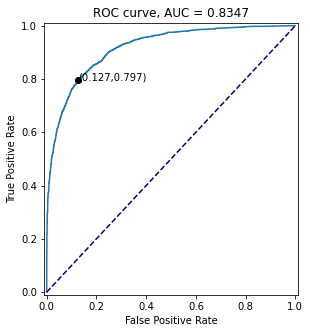

In [102]:
fpr, tpr, th = plot_ROC(targets_tensor, computed_scores)

In [73]:
def plot_rates(fpr, tpr, th):
    
    plt.plot(th, fpr)
    plt.plot(th, 1-tpr)
    plt.plot(th, tpr)
    
    plt.legend(['FPIR', 'FNIR', 'TPIR'])
    plt.xlabel('Thresholds')
    plt.ylabel('FPIR, FNIR')
    plt.show()

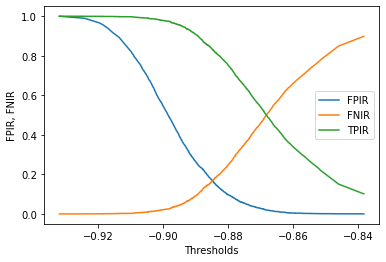

In [74]:
plot_rates(fpr[2:], tpr[2:], th[2:])

In [75]:
idx = -260
print("TAR @ FAR =", np.round(fpr[idx]*100,2), "(%) is", np.round(tpr[idx]*100,2), "(%)")
#tpr[idx], fpr[idx]

TAR @ FAR = 39.07 (%) is 95.53 (%)


### Rough

In [103]:
from deepface import DeepFace

2023-03-15 18:23:50.690322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 18:23:50.901403: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-15 18:23:52.110240: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/barc/.local/lib/python3.9/site-packages/cv2/../../lib64:/opt/anaconda3/lib
2023-0

Directory  /home/barc /.deepface created
Directory  /home/barc /.deepface/weights created


In [105]:
model = DeepFace.build_model("ArcFace")

2023-03-15 18:24:07.831760: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14038 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:65:00.0, compute capability: 8.6


arcface_weights.h5  will be downloaded to  /home/barc/.deepface/weights/arcface_weights.h5


ConnectionError: HTTPSConnectionPool(host='github.com', port=443): Max retries exceeded with url: /serengil/deepface_models/releases/download/v1.0/arcface_weights.h5 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f8968cdbe80>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))

In [ ]:
obj = DeepFace.verify(img1, img2, model_name = 'ArcFace', 
                      model=model, enforce_detection=False, detector_backend='opencv')
print(obj)